# The Dataset


In [ ]:
!pip install datasets
!pip install seqeval

In [ ]:
from datasets import get_dataset_config_names

In [ ]:
xtreme_subset = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subset)} configurations")

XTREME has 183 configurations


In [ ]:
panx_subsets = [s for s in xtreme_subset if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [ ]:
from datasets import load_dataset
load_dataset("xtreme", name="PAN-X.de") # de is the code for German

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [ ]:
from collections import defaultdict
from datasets import DatasetDict

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]

# Return a DatasetDict if key doesn't exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split aaccording to spoken fraction
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows)))
        )



In [ ]:
import pandas as pd
pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
                index=["Number of training examples"])



,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [ ]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}:\n {value}\n")

tokens:
 ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']

ner_tags:
 [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]

langs:
 ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']



In [ ]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}:\n {value}\n")

tokens:
 Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)

ner_tags:
 Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)

langs:
 Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)



In [ ]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [ ]:
def create_tag_names(batch):
    return {"ner_tags_str":[tags.int2str(idx) for idx in batch['ner_tags']]}


In [ ]:
print(tags.int2str([0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]))

['O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'B-LOC', 'B-LOC', 'I-LOC', 'O']


In [ ]:
for i in panx_ch['de']:
    print(i, end=",")

train,validation,test,

In [ ]:
for key in element["ner_tags"]:
    print(key, end=" ")

0 0 0 0 5 6 0 0 5 5 6 0 

In [ ]:
panx_de = panx_ch['de'].map(create_tag_names)

In [ ]:
de_example =panx_de["train"][0]
pd.DataFrame([de_example['tokens'], de_example['ner_tags_str']], ['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [ ]:
from collections import Counter

split2freqs = defaultdict(Counter)

for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1

pd.DataFrame.from_dict(split2freqs, orient="index")


,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


In [ ]:
split2freqs

defaultdict(collections.Counter,
            {'train': Counter({'LOC': 6186, 'ORG': 5366, 'PER': 5810}),
             'validation': Counter({'ORG': 2683, 'LOC': 3172, 'PER': 2893}),
             'test': Counter({'LOC': 3180, 'PER': 3071, 'ORG': 2573})})

# Multilingual Transformers

## A Closer Look at Tokenization

In [ ]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name) # WordPiece
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name) # SectencePiece

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()
bert_tokens, xlmr_tokens

(['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]'],
 ['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>'])

In [ ]:
"".join(xlmr_tokens).replace("▁", " ")

'<s> Jack Sparrow loves New York!</s>'

In [ ]:
"".join(xlmr_tokens).replace(u"\u2581", " ")

'<s> Jack Sparrow loves New York!</s>'

## Transformers for Named Entity Recognition


##Creating a Custom Model for Token Classification


In [ ]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel, RobertaPreTrainedModel

In [ ]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config, add_pooling_layer=False) # Model Body # "add_pooling_layer": ensure all hidden states are returned and not only the one associated with the [CLS] token.
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        # use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0]) # outputs.hidden_state
        logits = self.classifier(sequence_output)

        # Calculate losses
        loss = None
        if labels is not None:
            loss_fun = nn.CrossEntropyLoss()
            loss = loss_fun(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)

## Loading a Custom Model


In [ ]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2indedx = {tag: idx for idx, tag in enumerate(tags.names)}

In [ ]:
tags.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

In [ ]:
print(tag2indedx), tags.num_classes

{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6}


(None, 7)

In [ ]:
from transformers import AutoConfig

# Passing keyword arguments to the from_pretrained() method overrides the default values:
xlmr_config = AutoConfig.from_pretrained(
    xlmr_model_name, # xlm-roberta-base
    num_labels=tags.num_classes,
    id2label=index2tag,
    label2id=tag2indedx
)

In [ ]:
xlmr_config.num_labels

7

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (
    XLMRobertaForTokenClassification
    .from_pretrained(xlmr_model_name, config=xlmr_config)
    .to(device)
)

In [ ]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Inputs IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Inputs IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [ ]:
xlmr_tokens

['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']

In [ ]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of output: {outputs.shape}")

Number of tokens in sequence: 10
Shape of output: torch.Size([1, 10, 7])


In [ ]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens,preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC


In [ ]:
def tag_text(text, tags, model, tokenizer):
    tokens = tokenizer(text).tokens()
    inputs_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    outputs = model(inputs_ids)[0]
    predictions = torch.argmax(outputs, dim=2)
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])


### Tokenizing Texts for NER


In [ ]:
words, labels = de_example['tokens'], de_example['ner_tags']
tokenized_input = xlmr_tokenizer(words, is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [ ]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [ ]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:

    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l]if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []

    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs['labels'] = labels
    return tokenized_inputs



In [ ]:
ti = xlmr_tokenizer(panx_ch['de']["train"][:5]["tokens"], is_split_into_words=True, truncation=True)

In [ ]:
panx_ch['de']["train"][:5].keys()

dict_keys(['tokens', 'ner_tags', 'langs'])

In [ ]:
print(panx_ch['de']["train"][:5]['ner_tags'])

[[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0], [0, 0, 0, 3, 0, 0, 0, 3, 4, 0, 0], [0, 0, 0, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0], [0, 0, 3, 4, 0, 0], [0, 1, 2, 2, 2]]


In [ ]:
print(ti.word_ids(0))

[None, 0, 1, 1, 2, 3, 4, 4, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9, 9, 10, 10, 10, 11, 11, None]


In [ ]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True,
                      remove_columns=["langs", "ner_tags", "tokens"])


In [ ]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

In [ ]:
print(panx_de_encoded['train'][:2])

{'input_ids': [[0, 70101, 176581, 19, 142, 122, 2290, 708, 1505, 18363, 18, 23, 122, 127474, 15439, 13787, 14, 15263, 18917, 663, 6947, 19, 6, 5, 2], [0, 727, 8644, 39119, 23706, 20101, 24, 9703, 2400, 23, 68, 23513, 8913, 64658, 11251, 1659, 6, 5, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 0, 0, -100, 0, 0, 5, -100, -100, 6, -100, 0, 0, 5, -100, 5, -100, -100, -100, 6, -100, -100, 0, -100, -100], [-100, 0, 0, 0, 3, -100, 0, -100, -100, 0, 0, 3, -100, -100, 4, 0, 0, -100, -100]]}


In [ ]:
print(panx_ch["de"]['train'][:2])

{'tokens': [['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.'], ['Sie', 'geht', 'hinter', 'Walluf', 'nahtlos', 'in', 'die', 'Bundesautobahn', '66', 'über', '.']], 'ner_tags': [[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0], [0, 0, 0, 3, 0, 0, 0, 3, 4, 0, 0]], 'langs': [['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de'], ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']]}


### Performance measure

In [ ]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
 ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
["B-PER", "I-PER", "O"]]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [ ]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list


# Finetuning XLMRoberta

In [ ]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logginh_steps = len(panx_de_encoded['train']) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"

traning_args = TrainingArguments(
    output_dir=model_name,
    log_level="error",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    eval_strategy="epoch",
    save_steps=1e6,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logginh_steps,
    push_to_hub=True
)

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}


In [ ]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)


In [ ]:
def model_init():
    return (
        XLMRobertaForTokenClassification
        .from_pretrained(xlmr_model_name, config=xlmr_config)
        .to(device)
    )

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model_init=model_init,
    args=traning_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=panx_de_encoded["train"],
    eval_dataset=panx_de_encoded["validation"],
    tokenizer=xlmr_tokenizer,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


TypeError: 'collections.defaultdict' object is not callable

In [ ]:
# trainer.push_to_hub(commit_message="Training completed!")

events.out.tfevents.1727255179.a02b4b8d3787.992.1:   0%|          | 0.00/7.20k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/aman155/xlm-roberta-base-finetuned-panx-de/commit/3887768736beadc9030ce1da5a2a1a16cb571d6e', commit_message='Training completed!', commit_description='', oid='3887768736beadc9030ce1da5a2a1a16cb571d6e', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("aman155/xlm-roberta-base-finetuned-panx-de").to(device)
tokenizer = AutoTokenizer.from_pretrained("aman155/xlm-roberta-base-finetuned-panx-de")



In [ ]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, model, tokenizer)
# torch.argmax(model(tokenizer(text_de, return_tensors='pt').input_ids)[0], axis=2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


# Error analysis

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t))for t in zip(*batch.values())]
    batch = data_collator(features)
    # Move batch to device
    input_ids = batch.input_ids.to(device)
    attention_mask = batch.attention_mask.to(device)
    labels = batch.labels.to(device)
    # Forward pass
    with torch.no_grad():
        output = model(input_ids, attention_mask)
        # logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axi
        predicted_labels = torch.argmax(output.logits, axis=-1).cpu().numpy()
    loss = cross_entropy(output.logits.view(-1, 7),
                         labels.view(-1),
                         reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss": loss, "predicted_labels": predicted_labels}




In [ ]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

#### rough

In [ ]:
data_collator([dict(zip(valid_set[:1], t)) for t in zip(*valid_set[:1].values())])

{'input_ids': tensor([[    0, 10699,    11,    15, 16104,  1388,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]]), 'labels': tensor([[-100,    3, -100,    4,    4,    4, -100]])}

In [ ]:
[dict(zip(valid_set[:1], t)) for t in zip(*valid_set[:1].values())]

[{'input_ids': [0, 10699, 11, 15, 16104, 1388, 2],
  'attention_mask': [1, 1, 1, 1, 1, 1, 1],
  'labels': [-100, 3, -100, 4, 4, 4, -100]}]

In [ ]:
import torch
torch.ones((1, 10, 7))

tensor([[[1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.]]])

In [ ]:
torch.ones((1,7))

tensor([[1., 1., 1., 1., 1., 1., 1.]])

In [ ]:
torch.ones((1, 10, 7)).view(-1, 7)

tensor([[1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.]])

In [ ]:
torch.ones((1,7)).view(-1)

tensor([1., 1., 1., 1., 1., 1., 1.])

# Error analysis cont

In [ ]:
df.head()

,input_ids,attention_mask,labels,loss,predicted_labels
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[-100, 3, -100, 4, 4, 4, -100]","[0.0, 0.013388608, 0.0, 0.01115031, 0.00829453...","[4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, -100, -100, -100, -100, 3, -100, -10...","[0.0, 0.00026258358, 0.0, 0.0, 0.0, 0.0, 1.516...","[6, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 6, 6, 6, 6, ..."
2,"[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 0, 3, -100, -100, 0, -100, 0, ...","[0.0, 0.0001212285, 9.4647694e-05, 0.000112408...","[0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 5, -100, 0, 0, -100]","[0.0, 0.00015531764, 0.00014804698, 0.00016187...","[5, 0, 0, 0, 5, 6, 0, 0, 5, 5, 5, 5, 5, 5, 5, ..."
4,"[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, 3, ...","[0.0, 0.00011109689, 0.00011276563, 0.00011169...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, ..."


In [ ]:
index2tag[-100] = "IGN"
df['input_tokens'] = df['input_ids'].apply(
    lambda x: tokenizer.convert_ids_to_tokens(x)
)

df['predicted_labels'] = df['predicted_labels'].apply(
    lambda x: [index2tag[i] for i in x]
)
df['labels'] = df['labels'].apply(
    lambda x: [index2tag[i] for i in x]
)
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1
)
df['predicted_labels'] = df.apply(
    lambda x: x['predicted_labels'][:len(x['input_ids'])], axis=1
)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_labels,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.013388608, 0.0, 0.01115031, 0.00829453...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [ ]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens['loss'] = df_tokens['loss'].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_labels,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,1.52,B-LOC,▁Luz
1,10,1,I-ORG,2.72,I-LOC,▁a


In [ ]:
(
    df_tokens.groupby("input_tokens")[['loss']]
    .agg(['count',"mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T

)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁in,▁der,▁von,▁/,▁(,▁und,▁),▁'',▁die
count,6066,989,1388,808,163,246,1171,246,2898,860
mean,0.03,0.14,0.09,0.14,0.64,0.32,0.07,0.31,0.03,0.06
sum,205.19,136.77,127.08,113.73,103.89,79.13,76.95,76.39,75.53,53.74


In [ ]:
(
    df_tokens.groupby("labels")[['loss']]
    .agg(['count',"mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T

)

,0,1,2,3,4,5,6
labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1462,2683,3820,3172,2893,4139,43648
mean,0.62,0.6,0.52,0.32,0.26,0.18,0.03
sum,909.35,1600.7,1989.73,1012.79,756.77,758.01,1347.36


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

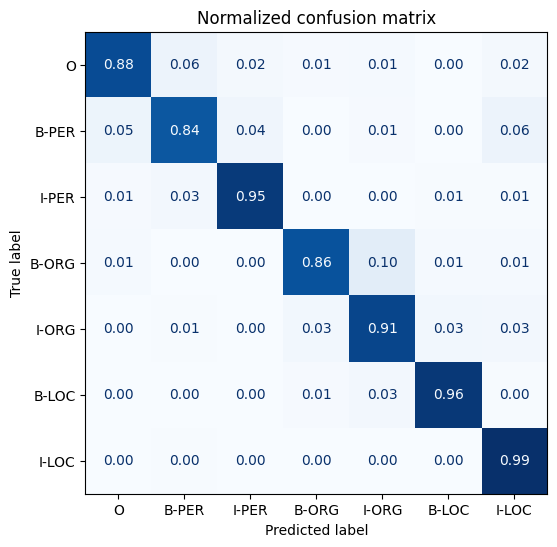

In [ ]:
import matplotlib.pyplot as plt
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_labels"],tags.names)

In [ ]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row['attention_mask'])-1}:
                labels.append(row['labels'][i])
                preds.append(row['predicted_labels'][i])
                tokens.append(row['input_tokens'][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({
                "tokens": tokens,
                "labels": labels,
                "preds": preds,
                "losses": losses
            }).T
        yield df_tmp


In [ ]:
df["total_loss"] = df['loss'].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

In [ ]:
# for sample in get_samples(df_tmp):
#     display(sample)

In [ ]:
df_tmp = df.loc[df['input_tokens'].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4
tokens,▁Ham,a,▁(,▁Unternehmen,▁)
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.01,0.00,0.01,0.01,0.01


,0,1,2,3,4,5,6
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁)
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.02,0.00,0.00,0.01,0.01,0.00,0.01


# Cross Lingual Transfer

In [ ]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [ ]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 0.009


In [ ]:
panx_de_encoded["test"].features

{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [ ]:
def forward_pass_with_label_f1(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t))for t in zip(*batch.values())]
    batch = data_collator(features)
    # Move batch to device
    input_ids = batch.input_ids.to(device)
    attention_mask = batch.attention_mask.to(device)
    labels = batch.labels.to(device)
    # Forward pass
    with torch.no_grad():
        output = model(input_ids, attention_mask)
    y_pred, y_true = align_predictions(output.logits.cpu().numpy(), labels.cpu().numpy())
    return {"y_pred": y_pred, "y_true": y_true}

In [ ]:
tmp = panx_de_encoded["test"].map(forward_pass_with_label_f1, batched=True, batch_size=128)

In [ ]:
f1_scores["de"]["de"] = f1_score(tmp["y_true"], tmp["y_pred"])
f1_scores["de"]["de"]

0.8657994030523174

In [ ]:
def evaluate_lang_performance_model(lang, model):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    tmp = panx_ds["test"].map(forward_pass_with_label_f1, batched=True, batch_size=128)
    return f1_score(tmp["y_true"], tmp["y_pred"])


In [ ]:
f1_scores["de"]["fr"] = evaluate_lang_performance_model("fr", model)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

F1-score of [de] model on [fr] dataset: 0.702


In [ ]:
f1_scores["de"]["it"] = evaluate_lang_performance_model("it", model)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

F1-score of [de] model on [it] dataset: 0.688


In [ ]:
f1_scores["de"]["en"] = evaluate_lang_performance_model("en", model)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

F1-score of [de] model on [en] dataset: 0.583


#  When Does Zero-Shot Transfer Make Sense?

In [ ]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset['train'].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset['validation']
    test_ds = dataset['test']

    traning_args.logging_steps = len(train_ds) // batch_size

    trainer = Trainer(
        model_init=model_init,
        args=traning_args,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        tokenizer=xlmr_tokenizer,
    )

    trainer.train()
    if traning_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")

    f1_score_ = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score_]}
    )


In [ ]:
panx_fr_encoded = encode_panx_dataset(panx_ch['fr'])

In [ ]:
traning_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

Epoch,Training Loss,Validation Loss,F1
1,1.554800,1.263193,0.000619
2,1.178600,1.021109,0.187658
3,0.986400,0.913967,0.256285


,num_samples,f1_score
0,250,0.038371


In [ ]:
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = pd.concat([metrics_df, train_on_subset(panx_fr_encoded, num_samples)])


Epoch,Training Loss,Validation Loss,F1
1,1.387200,1.049647,0.285346
2,0.851900,0.639669,0.602237
3,0.573200,0.547024,0.641789


Epoch,Training Loss,Validation Loss,F1
1,1.055700,0.535286,0.629635
2,0.476400,0.432378,0.701161
3,0.315100,0.381698,0.769078


Epoch,Training Loss,Validation Loss,F1
1,0.755000,0.409921,0.736433
2,0.314100,0.347460,0.792112
3,0.212900,0.326922,0.806209


Epoch,Training Loss,Validation Loss,F1
1,0.588600,0.331863,0.797347


In [ ]:
import matplotlib.pyplot as plt

plt.axhline(f1_scores["de"]['fr'], ls="--", c="r")
plt.plot(metrics_df['num_samples'], metrics_df['f1_score'])


In [ ]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]
        ).shuffle(seed=42)

    return multi_corpus

In [ ]:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [ ]:
panx_de_fr_encoded.num_rows, panx_de_encoded.num_rows, panx_fr_encoded.num_rows

In [ ]:
traning_args.logging_steps = len(panx_de_fr_encoded["train"])//batch_size
traning_args.push_to_hub = True
traning_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(
    model_init=model_init,
    args=traning_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer,
    train_dataset=panx_de_fr_encoded['train'],
    eval_dataset=panx_de_fr_encoded['validation']
)

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

In [ ]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [ ]:
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

In [ ]:
corpora = [panx_de_encoded]

for lang in langs[1:]:
    traning_args.output_dir = f"xlm-roberta-base-finetuned-panx-de-{lang}"
    encoded_ds = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(encoded_ds, encoded_ds["train"].num_rows)
    f1_scores[lang][lang] = metrics["f1_score"][0]
    corpora.append(encoded_ds)

In [ ]:
corpora_encoded = concatenate_splits(corpora)

In [ ]:
traning_args.logging_steps = len(corpora_encoded["train"])//batch_size
traning_args.push_to_hub = True
traning_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(
    model_init=model_init,
    args=traning_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer,
    train_dataset=corpora_encoded['train'],
    eval_dataset=corpora_encoded['validation'],
)

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")


In [ ]:
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])
scores_data = {
    "de": f1_scores["de"],
    "ecah": {lang: f1_scores[lang][lang] for lang in langs},
    "all": f1_scores["all"]
}

f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tuned on", columns="Evaluated on", inplace=True)

f1_scores_df
